In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

Khai báo tên file dùng để phân tích,định dạng lại cột date (loại bỏ giờ)

In [105]:
commit_file = pd.read_csv("data_processed/commits.csv")
commit_file['date'] = pd.to_datetime(commit_file['date'])
commit_file['month'] = commit_file['date'].dt.tz_localize(None).dt.to_period('M')

Phân tích commit


Tổng số commit từ tháng 8 năm 2019 đến tháng 12 năm 2023

In [106]:
total_commits = commit_file.shape[0]
print(f"Total number of commits: {total_commits}")

Total number of commits: 3517


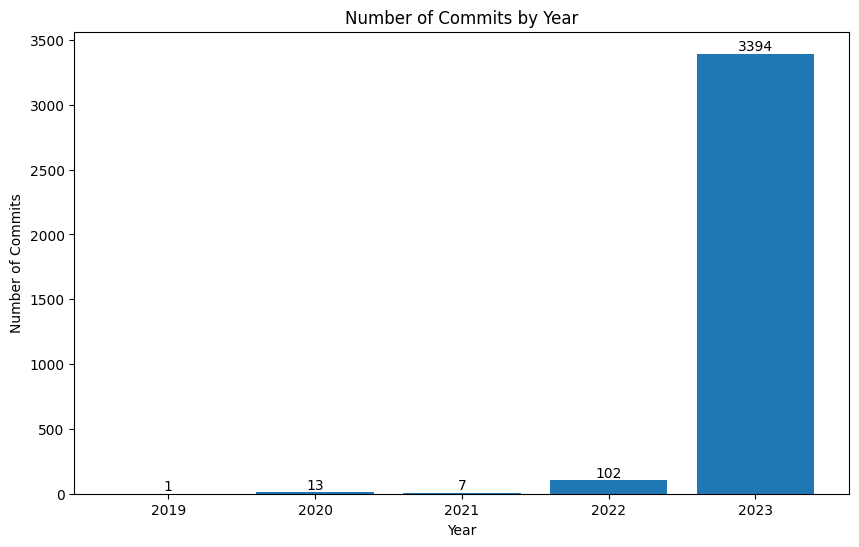

In [107]:
total_commits_per_year = commit_file['date'].dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(total_commits_per_year.index, total_commits_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Commits')
plt.title('Number of Commits by Year')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)
    
plt.show()

Phân tích tổng số commit theo tháng từ tháng 8 năm 2019 đến tháng 12 năm 2023


C:\Users\admin\AppData\Local\Temp\ipykernel_3160\2295019465.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commits_by_date = commit_file.groupby(commit_file['date'].dt.to_period('M')).size()


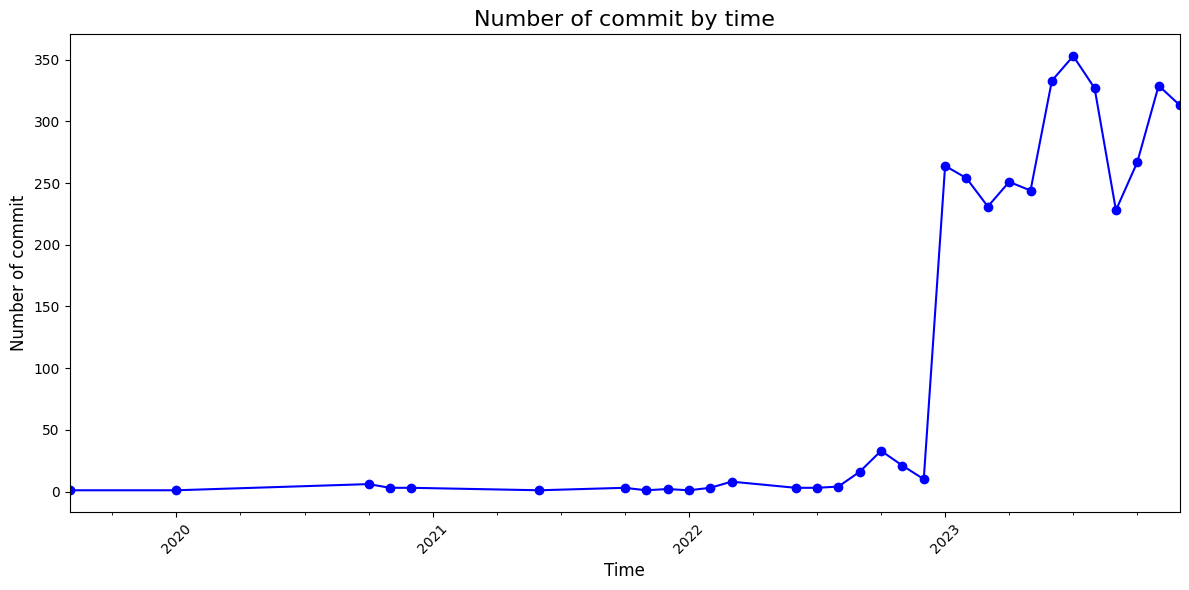

In [108]:
commit_counts = commit_file['month'].value_counts().sort_index()
commits_by_date = commit_file.groupby(commit_file['date'].dt.to_period('M')).size()
fig, ax = plt.subplots(figsize=(12, 6))
commits_by_date.plot(ax=ax, marker='o', color='b', label='Commits')
ax.set_title("Number of commit by time", fontsize=16)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Number of commit", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

Top 5 tháng có số lượt commit cao nhất

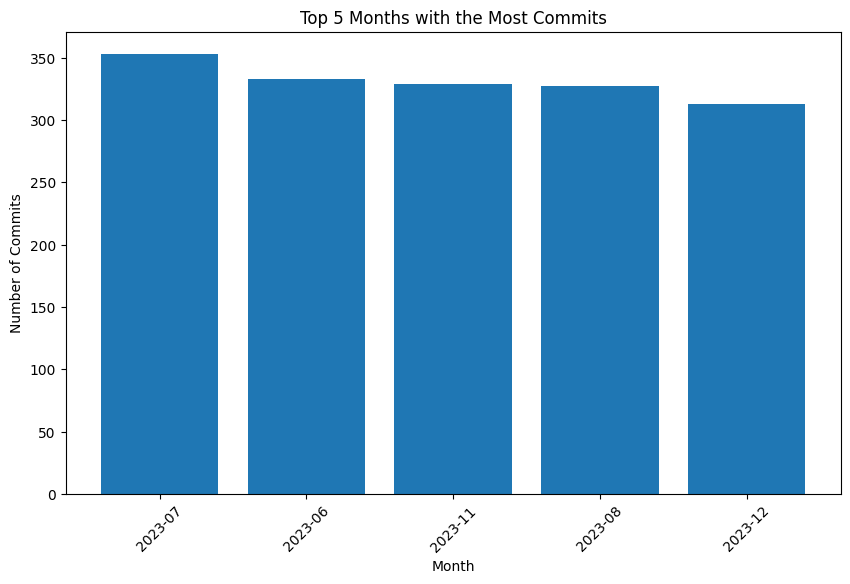

In [109]:
top_5_monthscommits = commit_counts.nlargest(5)

plt.figure(figsize=(10, 6))
plt.bar(top_5_monthscommits.index.astype(str), top_5_monthscommits.values)
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.title('Top 5 Months with the Most Commits')
plt.show()

Top 5 ngày có số lượt commit nhiều nhất

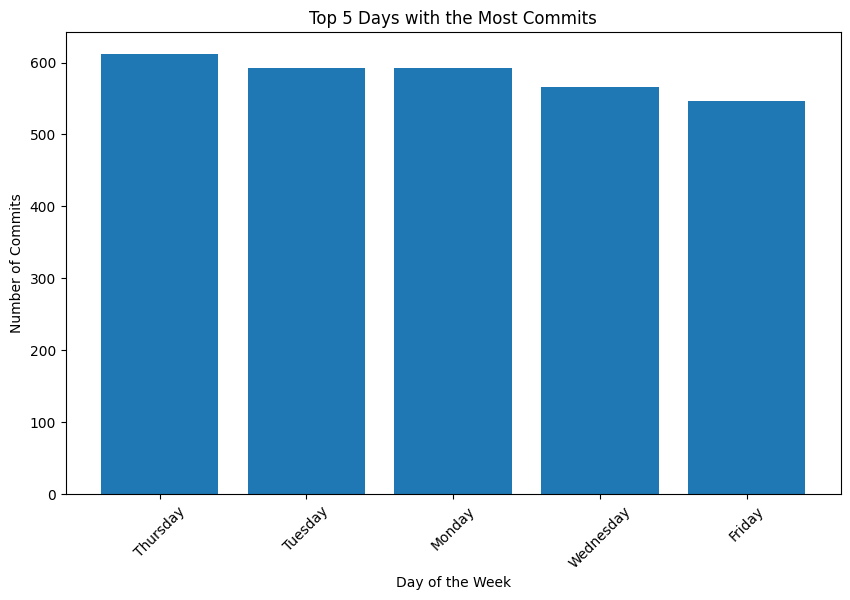

In [110]:
Top_5_weekdays_commits = commit_file['date'].dt.day_name().value_counts().nlargest(5)

plt.figure(figsize=(10, 6))
plt.bar(Top_5_weekdays_commits.index, Top_5_weekdays_commits.values)
plt.xticks(rotation=45)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Commits')
plt.title('Top 5 Days with the Most Commits')
plt.show()

Tương quan giữa số commit cuối tuần với những commit đầu tuần

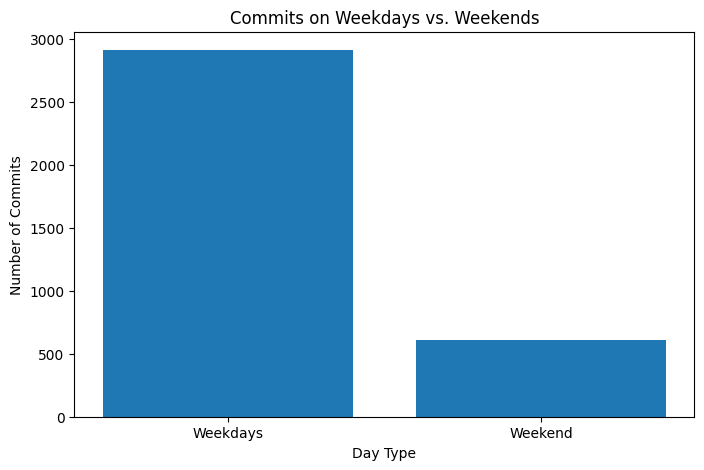

In [111]:
commit_file['is_weekend'] = commit_file['date'].dt.dayofweek >= 5
weekend_commits = commit_file['is_weekend'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(['Weekdays', 'Weekend'], [len(commit_file) - weekend_commits[True], weekend_commits[True]])
plt.xlabel('Day Type')
plt.ylabel('Number of Commits')
plt.title('Commits on Weekdays vs. Weekends')
plt.show()


Tổng số lượt commit theo giờ trong ngày

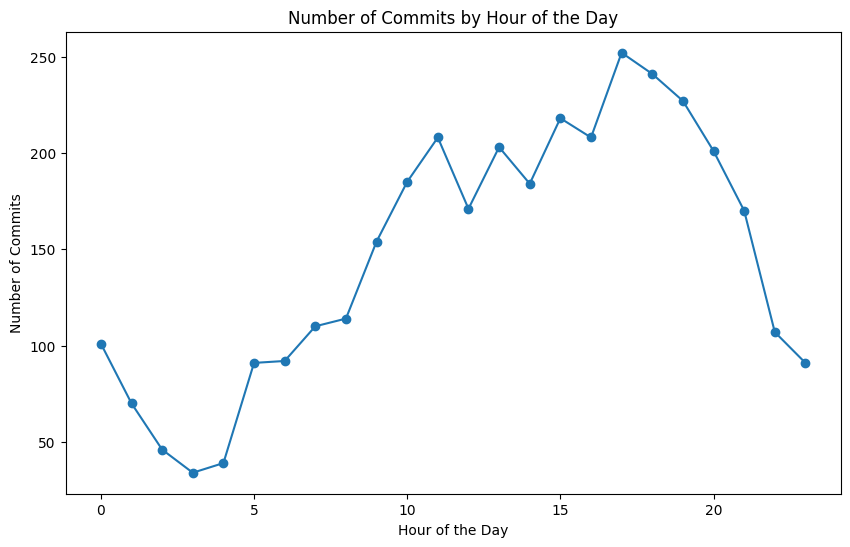

In [112]:
commit_counts_hour = commit_file['date'].dt.hour.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(commit_counts_hour.index, commit_counts_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Commits')
plt.title('Number of Commits by Hour of the Day')
plt.show()

Top 5 giờ có nhiều commit nhất

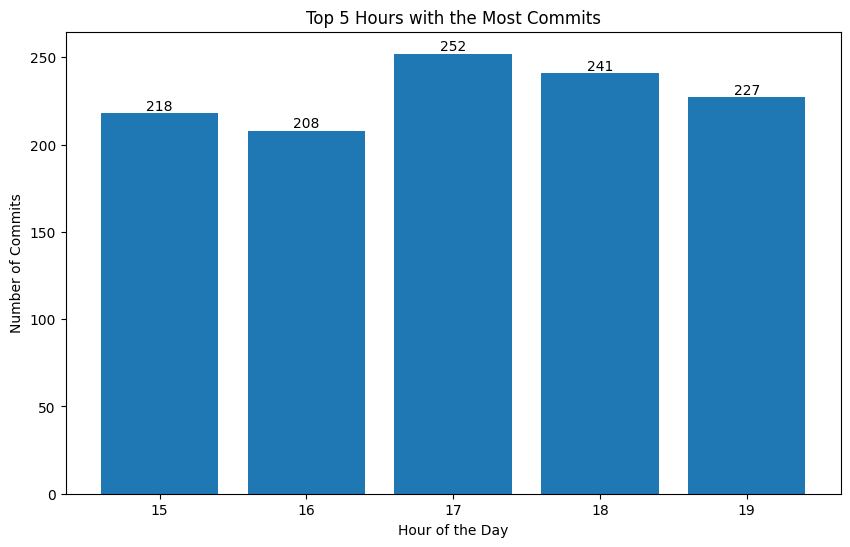

In [113]:
Top_5_hours_commits = commit_file['date'].dt.hour.value_counts().nlargest(5)

plt.figure(figsize=(10, 6))
bars = plt.bar(Top_5_hours_commits.index, Top_5_hours_commits.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Commits')
plt.title('Top 5 Hours with the Most Commits')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=10)
plt.show()


Tổng số lần files_changed 

In [114]:
total_files_changed = commit_file['files_changed'].sum()
print(f"Total number of files changed: {total_files_changed}")

Total number of files changed: 24419


Trung bình số lần file bị thay đổi mỗi lần commit

In [115]:
Avg_files_changed = commit_file['files_changed'].mean()
print(f"Average number of files changed: {Avg_files_changed}")

Average number of files changed: 6.943133352288883


Tổng số file thay đổi theo tháng

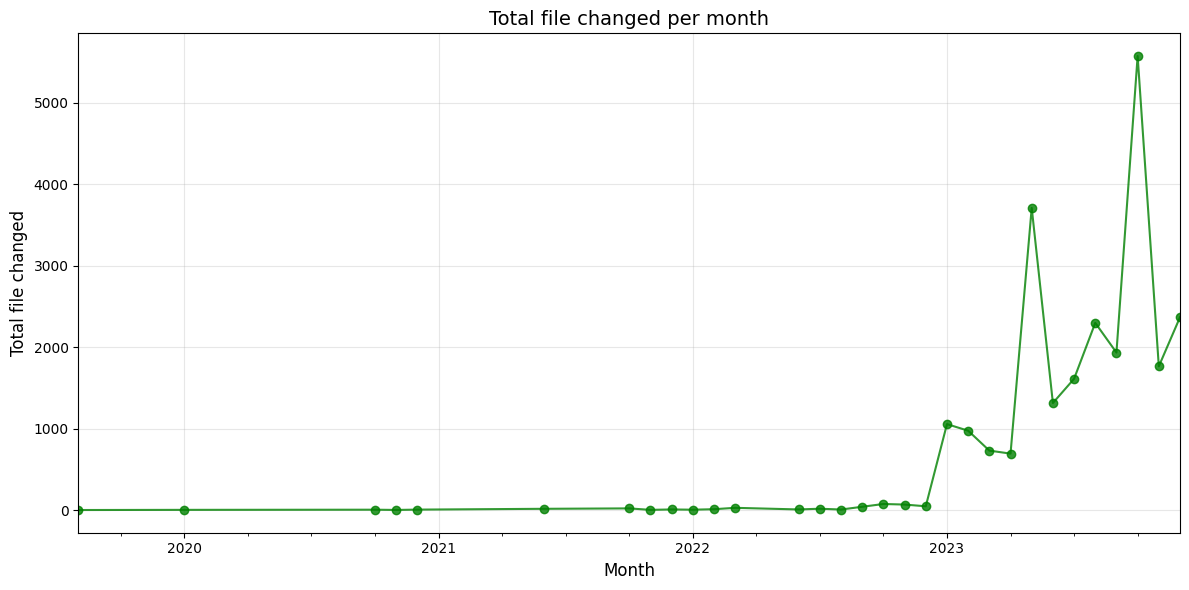

In [116]:
files_changed_per_month = commit_file.groupby('month')['files_changed'].sum()
plt.figure(figsize=(12, 6))
files_changed_per_month.plot(kind='line', marker='o', color='green', alpha=0.8)
plt.title('Total file changed per month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total file changed', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Top 5 commit có nhiều file thay đổi nhất

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\2427665139.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


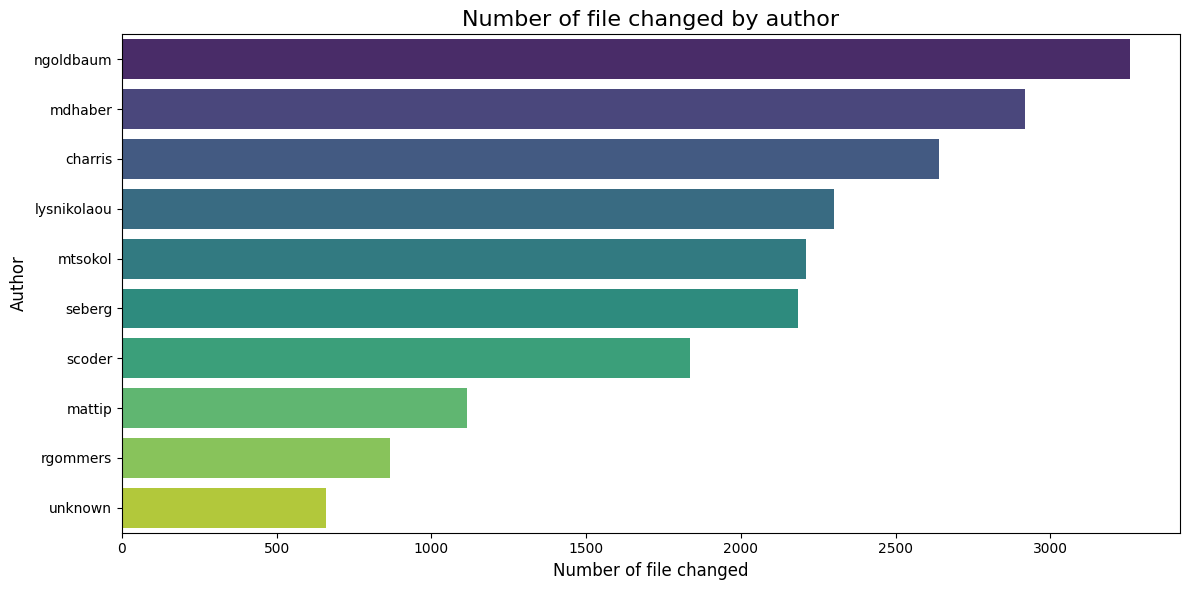

In [117]:
Top_5_commits_files_changed = authors_files_changed = commit_file.groupby('author')['files_changed'].sum().sort_values(ascending=False).reset_index().head(10)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=authors_files_changed,
    x='files_changed',
    y='author',
    palette='viridis',
    orient='h'
)
ax.set_title("Number of file changed by author", fontsize=16)
ax.set_xlabel("Number of file changed", fontsize=12)
ax.set_ylabel("Author", fontsize=12)
plt.tight_layout()
plt.show()


Phân bố số lượng tệp thay đổi của mỗi commit

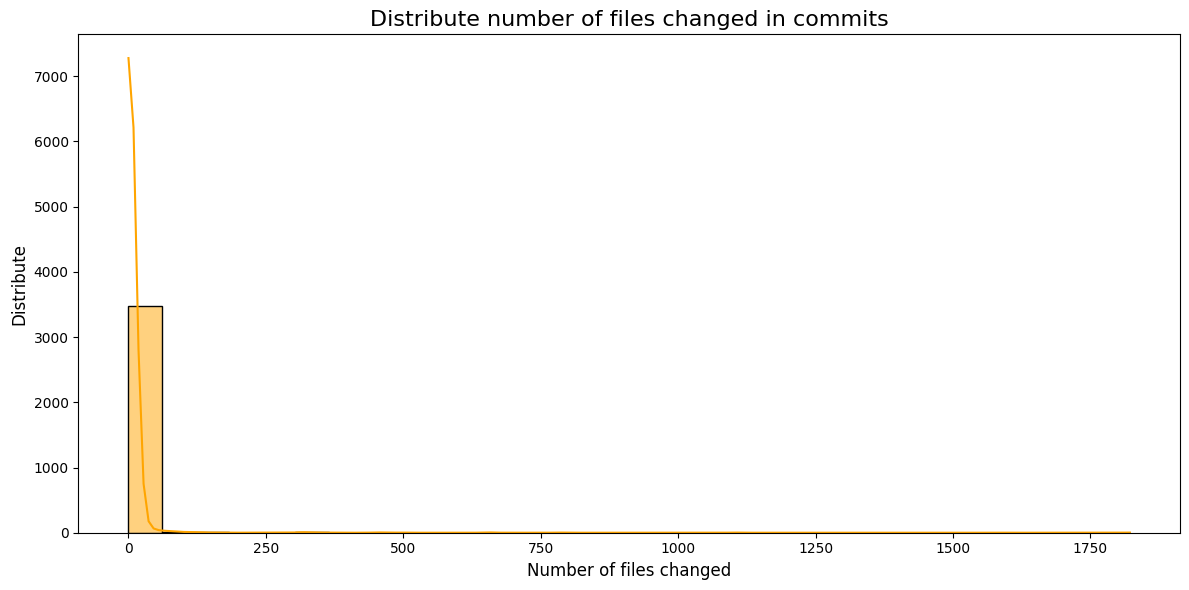

In [118]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(commit_file['files_changed'], bins=30, kde=True, color='orange', ax=ax)
ax.set_title("Distribute number of files changed in commits", fontsize=16)
ax.set_xlabel("Number of files changed", fontsize=12)
ax.set_ylabel("Distribute", fontsize=12)
plt.tight_layout()

In [119]:
# Xác định các commits có số lượng file thay đổi vượt quá ngưỡng bất thường (outliers)
# Sử dụng IQR để tìm ngưỡng bất thường
Q1 = commit_file['files_changed'].quantile(0.25)
Q3 = commit_file['files_changed'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Lọc các commits có số file thay đổi > ngưỡng
outliers = commit_file[commit_file['files_changed'] > outlier_threshold]
outliers_summary = {
    "Q1 (25%)": Q1,
    "Q3 (75%)": Q3,
    "IQR": IQR,
    "Outlier threshold": outlier_threshold,
    "Number of outliers": len(outliers)
}

outliers_summary

{'Q1 (25%)': np.float64(1.0),
 'Q3 (75%)': np.float64(3.0),
 'IQR': np.float64(2.0),
 'Outlier threshold': np.float64(6.0),
 'Number of outliers': 424}

top 10 commit với tổng số lượt file changed nhiều nhất

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\656947934.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_details, x='sha', y='files_changed', palette='viridis')


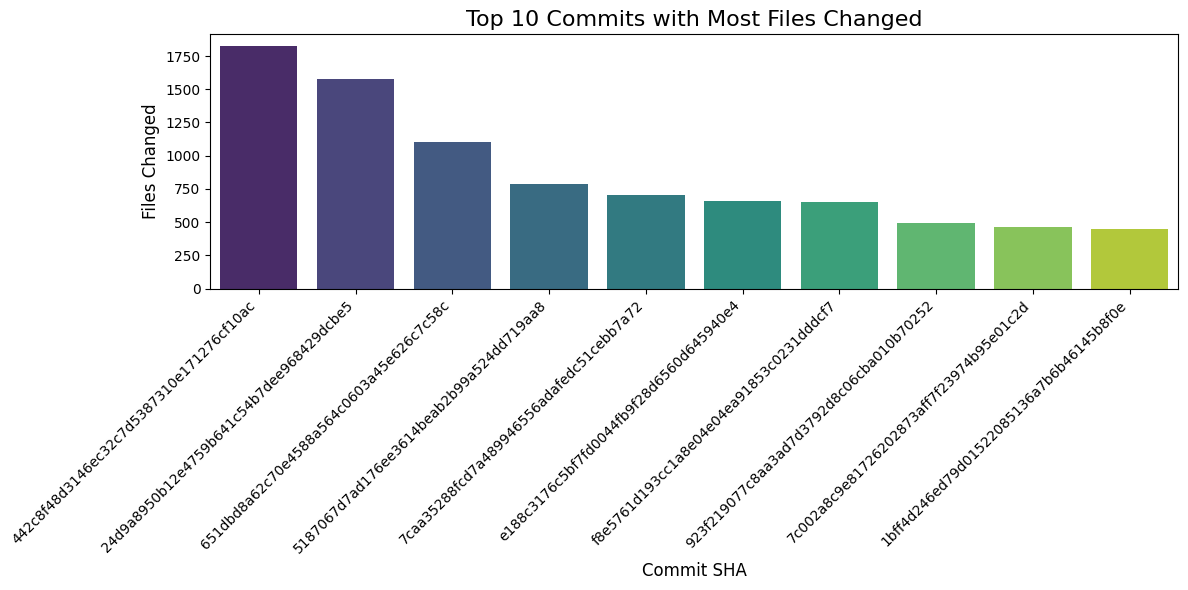

In [120]:
outlier_details = outliers[['sha', 'author', 'date', 'files_changed', 'message']].sort_values(by='files_changed', ascending=False).head(10)

# Vẽ biểu đồ cột
plt.figure(figsize=(12, 6))
sns.barplot(data=outlier_details, x='sha', y='files_changed', palette='viridis')

# Tùy chỉnh biểu đồ
plt.title('Top 10 Commits with Most Files Changed', fontsize=16)
plt.xlabel('Commit SHA', fontsize=12)
plt.ylabel('Files Changed', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Xoay nhãn SHA để dễ đọc
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

Xu hướng thay đổi số lượng tệp theo thời gian

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\980670043.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commit_file['month'] = commit_file['date'].dt.to_period('M')


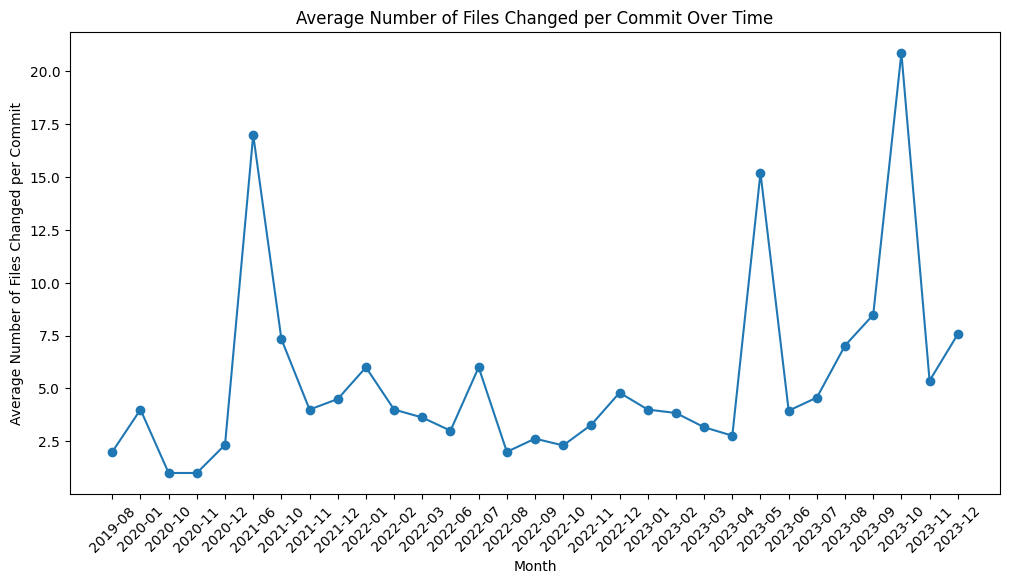

In [121]:
commit_file['month'] = commit_file['date'].dt.to_period('M')
avg_files_changed_per_month = commit_file.groupby('month')['files_changed'].mean()

plt.figure(figsize=(12, 6))
plt.plot(avg_files_changed_per_month.index.astype(str), avg_files_changed_per_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Average Number of Files Changed per Commit')
plt.title('Average Number of Files Changed per Commit Over Time')
plt.xticks(rotation=45)
plt.show()

Tổng số commit ít thay đổi (1-2 files_chaged) so với trung bình (3-10 file_changed) và thay đổi lớn (>10 file_changed)

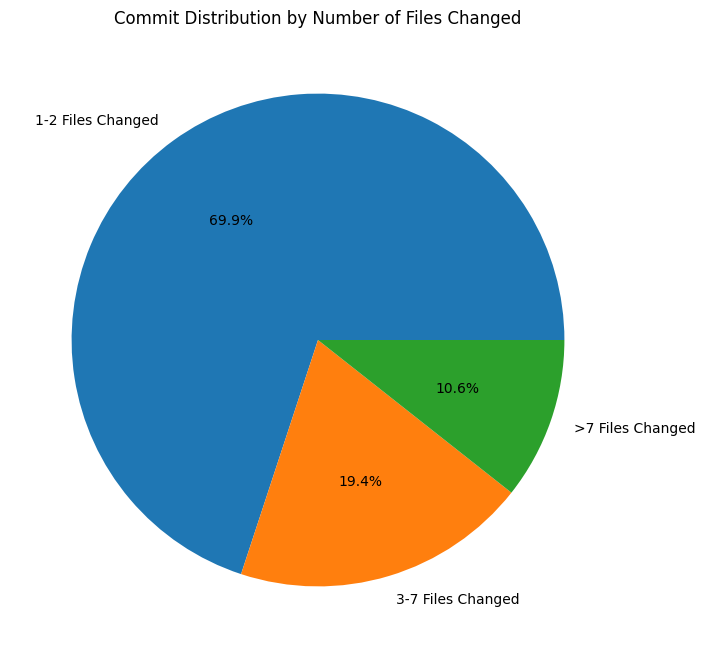

In [122]:
few_changes = commit_file[commit_file['files_changed'] <= 2]
medium_changes = commit_file[(commit_file['files_changed'] > 2) & (commit_file['files_changed'] <= 7)]
many_changes = commit_file[commit_file['files_changed'] > 7]

commit_distribution = [len(few_changes), len(medium_changes), len(many_changes)]
labels = ['1-2 Files Changed', '3-7 Files Changed', '>7 Files Changed']
plt.figure(figsize=(8, 8))
plt.pie([len(few_changes), len(medium_changes), len(many_changes)], labels=labels, autopct='%1.1f%%')
plt.title('Commit Distribution by Number of Files Changed')
plt.show()

Tổng số file thay đổi theo tác giả

In [123]:
total_files_changed_author = commit_file.groupby(commit_file['author'])['files_changed'].sum().sort_values(ascending=False)
print("Total number of files changed by each author: ", total_files_changed_author)

Total number of files changed by each author:  author
ngoldbaum        3256
mdhaber          2918
charris          2639
lysnikolaou      2300
mtsokol          2209
                 ... 
agctute             1
albanie             1
andersonm-ibm       1
nbehrnd             1
florath             1
Name: files_changed, Length: 231, dtype: int64


Tổng commit theo từng tác giả

In [124]:
total_commits_author = commit_file.groupby(commit_file['author']).size().sort_values(ascending=False)
print("Total number of commits by each author: ", total_commits_author)

Total number of commits by each author:  author
seberg           631
charris          424
mattip           317
rgommers         237
ngoldbaum        220
                ... 
graingert          1
h-mayorquin        1
helloworld922      1
honno              1
zrottman           1
Length: 231, dtype: int64


Tổng số tác giả 

In [125]:
Totals_authors = commit_file['author'].nunique()
print("Total number of authors: ", Totals_authors)

Total number of authors:  231


Số lượng file thay đổi theo tác giả

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\623591235.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=files_changed_by_author.values, y=files_changed_by_author.index, palette='viridis', ax=ax)


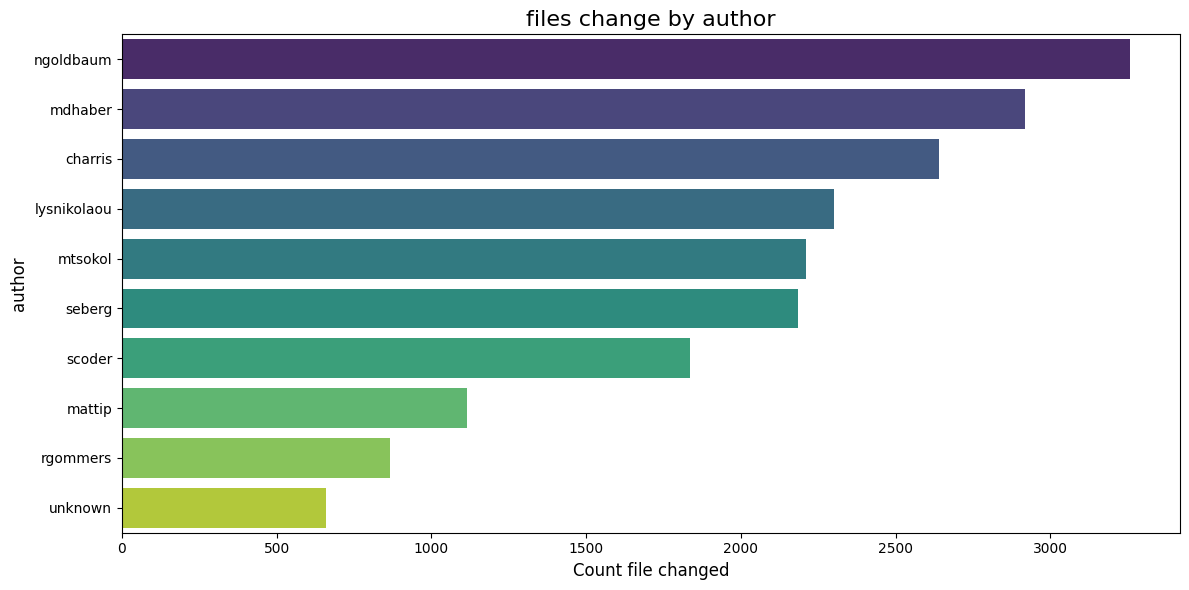

In [126]:
files_changed_by_author = commit_file.groupby('author')['files_changed'].sum().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=files_changed_by_author.values, y=files_changed_by_author.index, palette='viridis', ax=ax)
ax.set_title("files change by author", fontsize=16)
ax.set_xlabel("Count file changed", fontsize=12)
ax.set_ylabel("author", fontsize=12)
plt.tight_layout()
plt.show()

phần trăm file thay đổi của các tác giả nổi bật

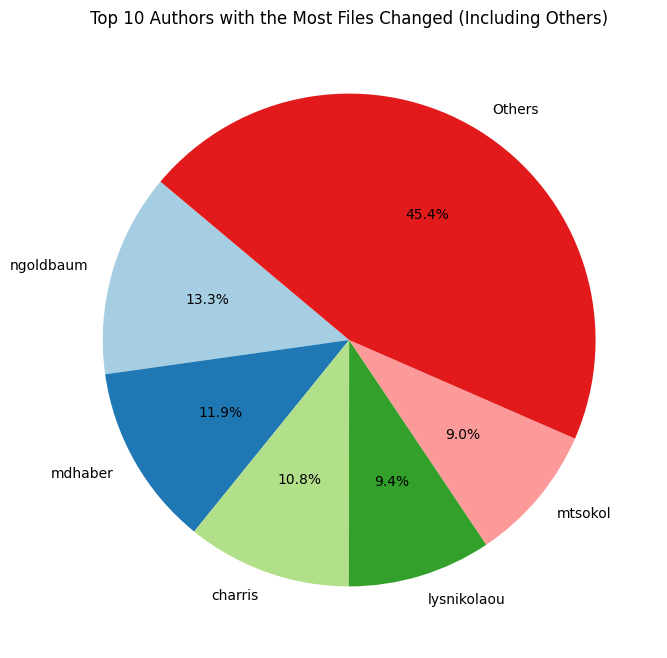

In [127]:
top_authors = total_files_changed_author.nlargest(5)
others_sum = total_files_changed_author[5:].sum()
top_authors['Others'] = others_sum

plt.figure(figsize=(12, 8))
plt.pie(top_authors, labels=top_authors.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Authors with the Most Files Changed (Including Others)')
plt.show()


phần trăm commit của các tác giả nổi bật

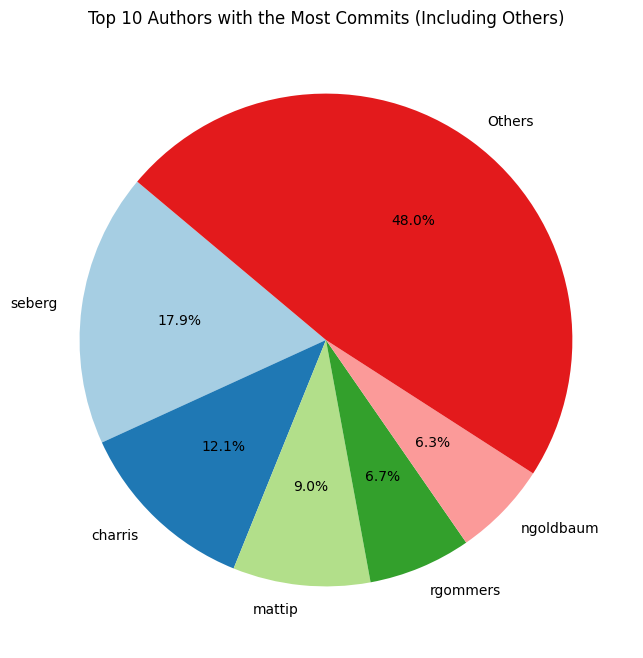

In [128]:
top_authors = total_commits_author.nlargest(5)
others_sum = total_commits_author[5:].sum()
top_authors['Others'] = others_sum

plt.figure(figsize=(12, 8))
plt.pie(top_authors, labels=top_authors.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Authors with the Most Commits (Including Others)')
plt.show()

Phân loại từ xuất hiện trong nội dung commit

In [129]:
# Gắn nhãn các commit dựa trên từ khóa trong phần mô tả
commit_file['commit_type'] = commit_file['message'].apply(
    lambda x: 'Bug fix' if 'BUG' in x.upper() else
              'Enhancement' if 'ENH' in x.upper() else
              'Documentation' if 'DOC' in x.upper() else
              'Refactor' if 'REF' in x.upper() else 
              'Test case' if 'TST' in x.upper() else 
              'Maintenance' if 'MAINT' in x.upper() else None
)

vẽ biểu đồ tổng số commit với mỗi nhóm đó

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\1303456502.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=commit_type_counts.values, y=commit_type_counts.index, palette='cool', ax=ax)


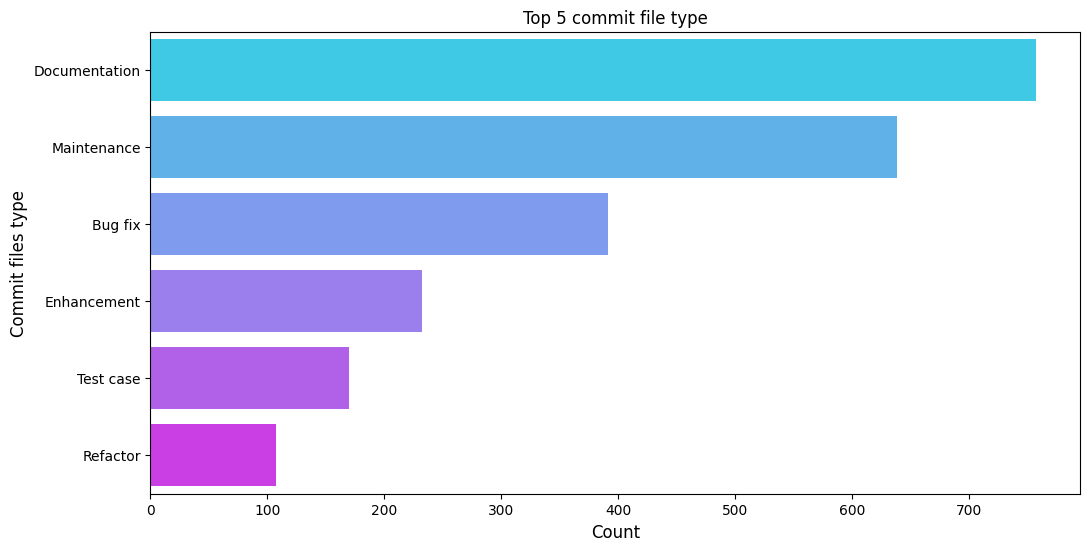

In [130]:
# Đếm số lượng commit theo loại
commit_type_counts = commit_file['commit_type'].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=commit_type_counts.values, y=commit_type_counts.index, palette='cool', ax=ax)



# Vẽ biểu đồ cột

ax.set_title('Top 5 commit file type')
ax.set_xlabel("Count",fontsize = 12)
ax.set_ylabel("Commit files type",fontsize = 12)
plt.show()

nhóm các commit theo tháng và loại 

In [131]:
commit_file['month'] = commit_file['date'].dt.to_period('M')
commit_trends = commit_file.groupby(['month', 'commit_type']).size().unstack(fill_value=0)

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\1097665846.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  commit_file['month'] = commit_file['date'].dt.to_period('M')


Tìm 5 từ khóa xuất hiện nhiều nhất trong phần nội dung commit (có 1 chút áp dụng xử lí ngôn ngữ tự nhiên)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\admin\AppData\Local\Temp\ipykernel_3160\3456593293.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=ax)


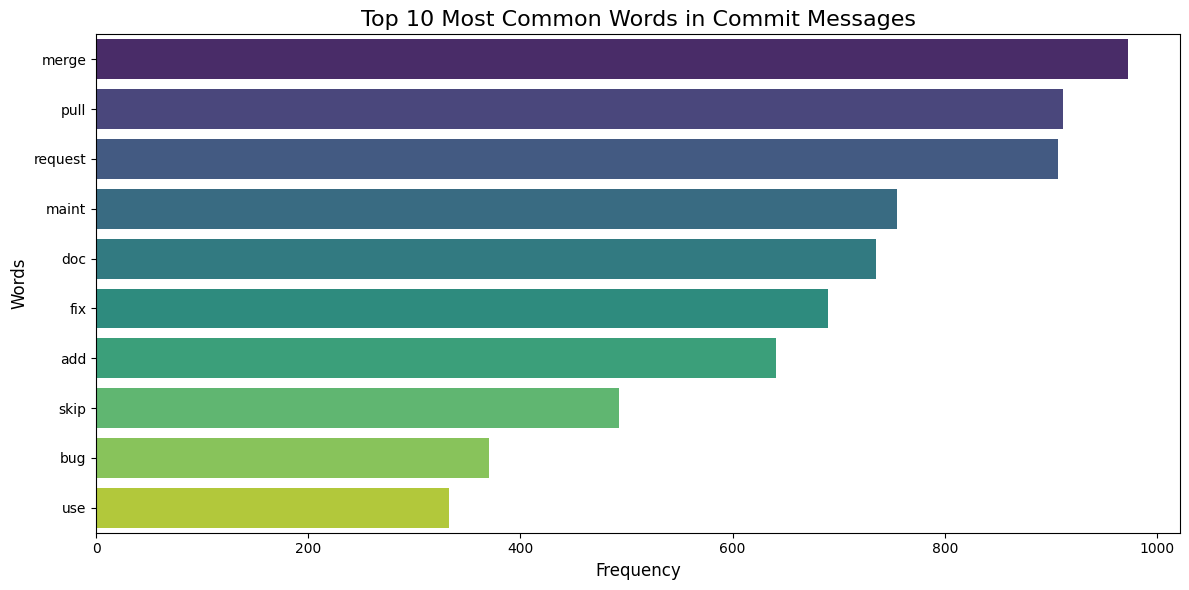

In [132]:
# Download NLTK stopwords
nltk.download('stopwords')

# Load stop words
stop_words = set(stopwords.words('english'))

# Ensure 'commit_file' and its 'message' column exist
if 'commit_file' in locals() and 'message' in commit_file.columns:
    # Combine all commit messages into a single text
    all_messages = ' '.join(commit_file['message'].astype(str))

    # Clean text: remove special characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_messages).lower()

    # Tokenize and remove stopwords
    words = [word for word in cleaned_text.split() if word not in stop_words]

    # Count word frequencies
    word_counts = Counter(words)

    # Get the 10 most common words
    top_10_words = word_counts.most_common(10)

    # Prepare data for plotting
    words, counts = zip(*top_10_words)

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=ax)
    ax.set_title('Top 10 Most Common Words in Commit Messages', fontsize=16)
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_ylabel('Words', fontsize=12)
    plt.tight_layout()
    plt.show()

Tổng số file đã commit

In [133]:
total_files_commited = commit_file['files_commited'].nunique()
print("Total number of files: ", total_files_commited)

Total number of files:  1708


Top 10 file đã commit được thay đổi nhiều nhất

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\3723025428.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


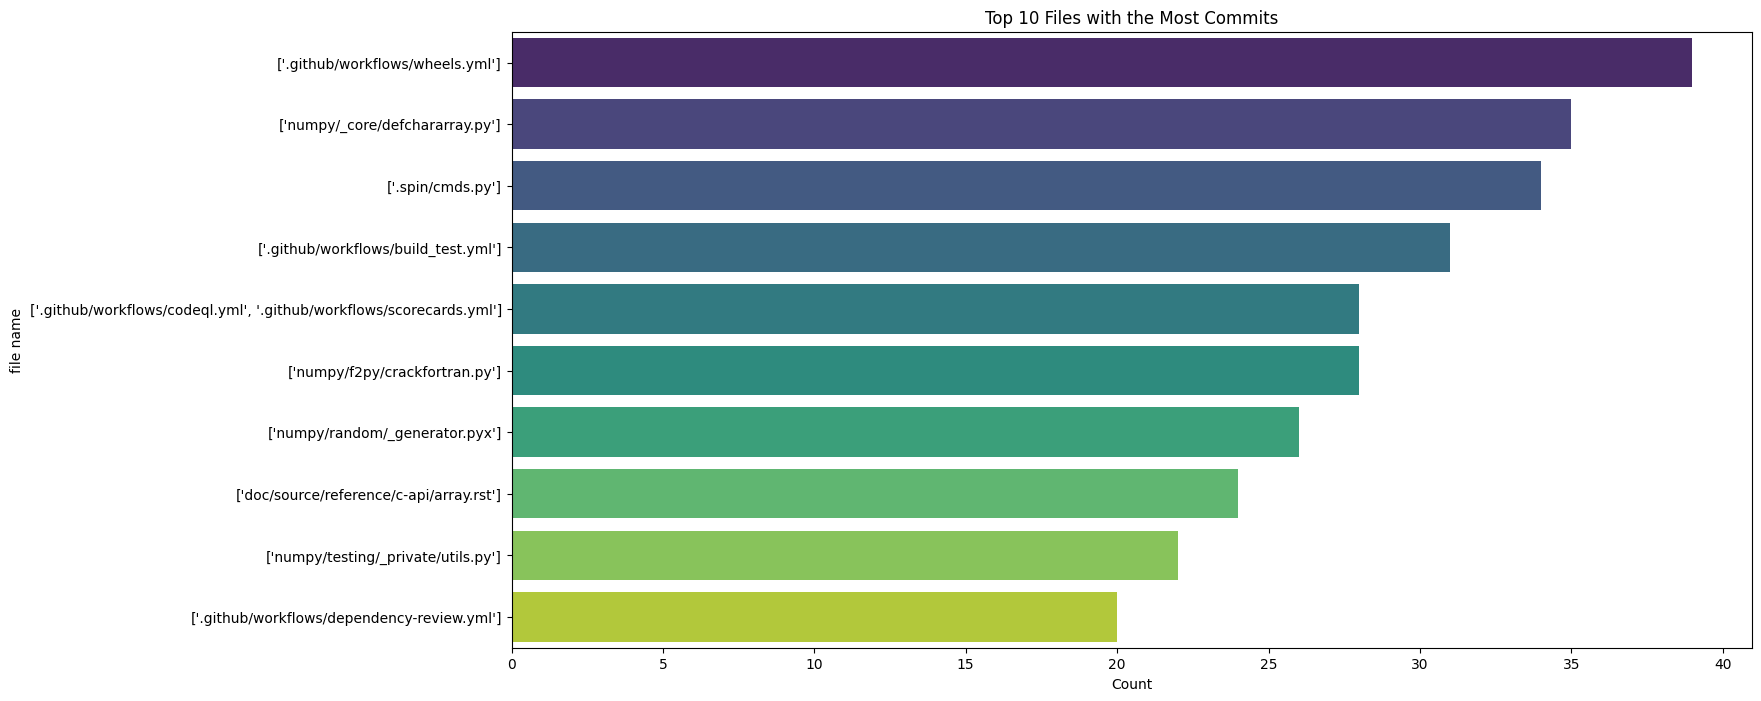

In [134]:
Top_5_files_commited_most_changed = commit_file['files_commited'].value_counts().nlargest(10)

Top_5_files_commited_most_changed_df = Top_5_files_commited_most_changed.reset_index()
Top_5_files_commited_most_changed_df.columns = ['file name','Count']
plt.figure(figsize=(16, 8))
sns.barplot(
    y='file name',
    x='Count',
    
    data=Top_5_files_commited_most_changed_df,
    palette='viridis'
)
plt.title('Top 10 Files with the Most Commits')
plt.show()

phân tích loại tệp được thay đổi nhiều nhất

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\681419575.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


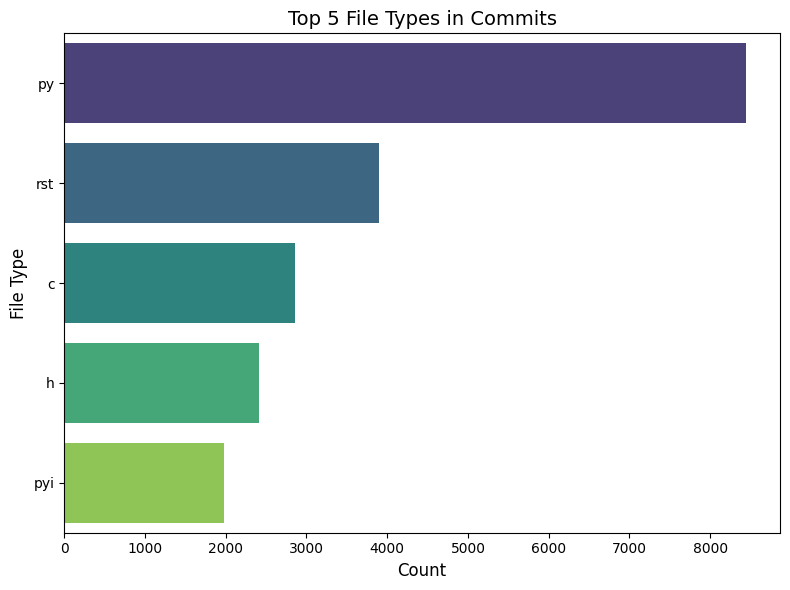

In [135]:

file_extensions = commit_file['files_commited'].str.extractall(r'\.(\w+)')[0]
file_counts = file_extensions.value_counts()

top_file_counts = file_counts.head(5)
other_count = file_counts[5:].sum()

top_file_counts_df = top_file_counts.reset_index()
top_file_counts_df.columns = ['File Type', 'Count']

top_file_counts['Other'] = other_count
plt.figure(figsize=(8, 6))
sns.barplot(
    y='File Type',
    x='Count',
    data=top_file_counts_df,
    palette='viridis'
)

plt.title("Top 5 File Types in Commits", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("File Type", fontsize=12)

plt.tight_layout()
plt.show()

so sánh số lượng các core file và non core file trong dự án

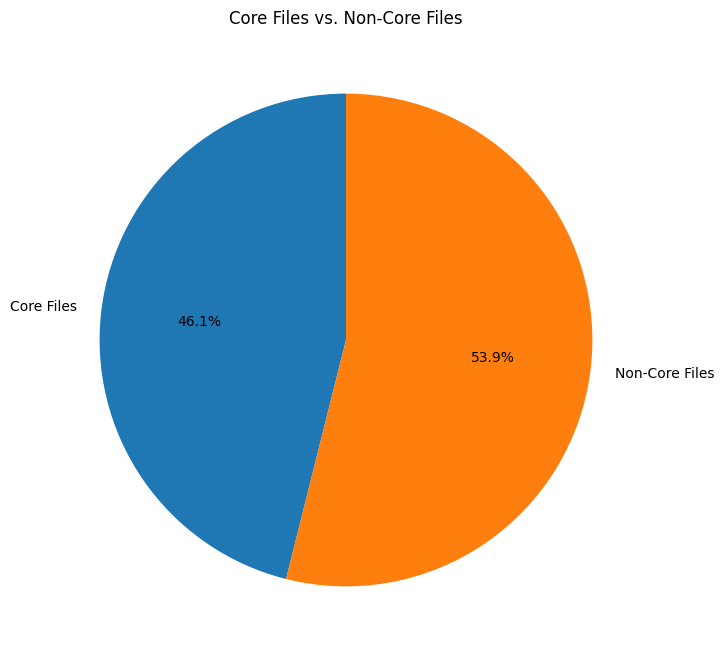

In [136]:
Total_core_files = commit_file['files_commited'].str.contains('core').sum()
Total_non_core_files = commit_file['files_commited'].str.contains('core').count() - Total_core_files

plt.figure(figsize=(8, 8))
labels = ['Core Files', 'Non-Core Files']
sizes = [Total_core_files, Total_non_core_files]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Core Files vs. Non-Core Files')
plt.show()

tần suất thay đổi của các core file so với các non core file

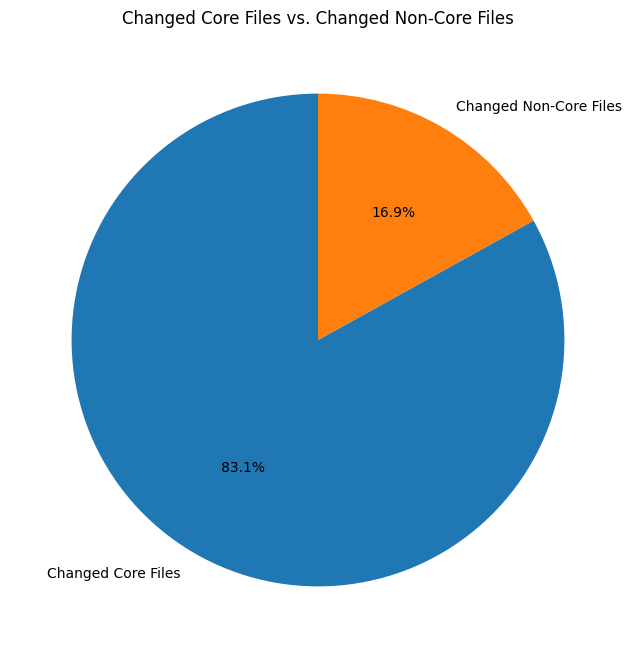

In [137]:
Total_changed_core_files = commit_file[commit_file['files_commited'].str.contains('core')]['files_changed'].sum()
Total_changed_non_core_files = commit_file[~commit_file['files_commited'].str.contains('core')]['files_changed'].sum()

plt.figure(figsize=(8, 8))
labels = ['Changed Core Files', 'Changed Non-Core Files']
sizes = [Total_changed_core_files, Total_changed_non_core_files]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Changed Core Files vs. Changed Non-Core Files')
plt.show()

so sánh tỉ lệ lỗi của core file với non core file

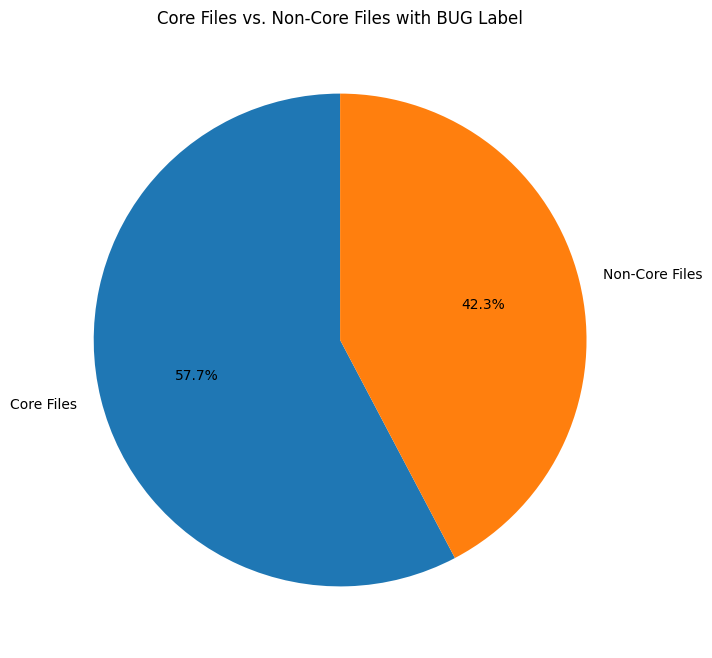

In [138]:
Total_core_files_have_BUG_label = commit_file[commit_file['files_commited'].str.contains('core') & commit_file['message'].str.contains('BUG')]['files_commited'].count()
Total_non_core_files_have_BUG_label = commit_file[~commit_file['files_commited'].str.contains('core') & commit_file['message'].str.contains('BUG')]['files_commited'].count()

plt.figure(figsize=(8, 8))
labels = ['Core Files', 'Non-Core Files']
sizes = [Total_core_files_have_BUG_label, Total_non_core_files_have_BUG_label]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Core Files vs. Non-Core Files with BUG Label')
plt.show()

Phân bố số lượng file thay đổi của core file và non core file

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\2722102003.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True, showfliers=True)


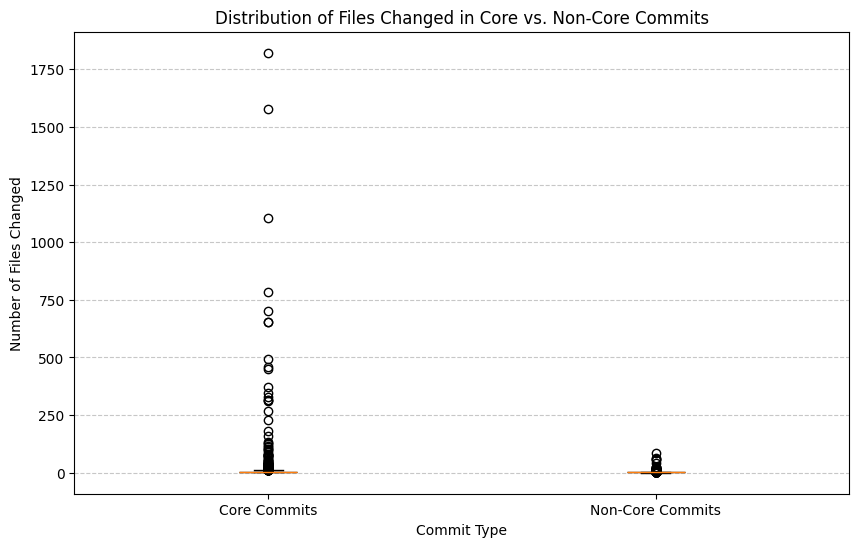

In [139]:
# Identify core commits (contains 'core' in file paths) and non-core commits
commit_file['is_core_commit'] = commit_file['files_commited'].str.contains('core', case=False, na=False)

# Separate core and non-core commits
core_commits = commit_file[commit_file['is_core_commit']]
non_core_commits = commit_file[~commit_file['is_core_commit']]

# Prepare data for box plot (assuming 'files_changed' column exists)
data = [core_commits['files_changed'], non_core_commits['files_changed']]
labels = ['Core Commits', 'Non-Core Commits']

# Plotting the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True, showfliers=True)
plt.title('Distribution of Files Changed in Core vs. Non-Core Commits')
plt.ylabel('Number of Files Changed')
plt.xlabel('Commit Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

phân tích xem tệp nào hay được các tác giả khác nhau chỉnh sửa 

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\1223373403.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


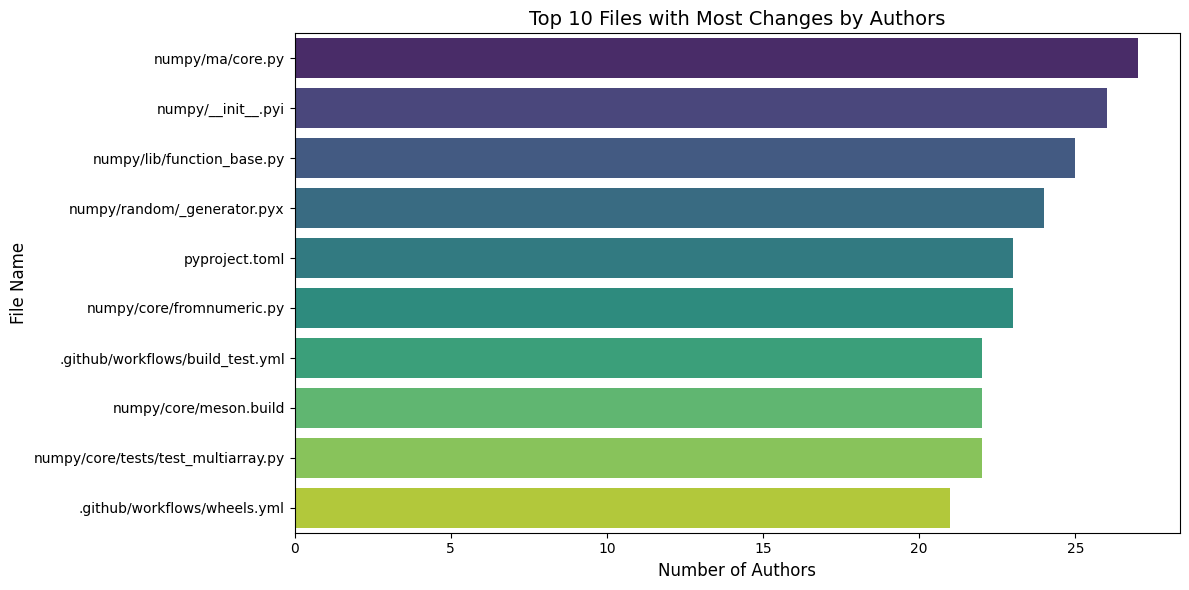

In [140]:

commit_file['files_commited_clean'] = (
    commit_file['files_commited']
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ")
)

file_author_stats = (
    commit_file.explode('files_commited_clean')
    .groupby('files_commited_clean')['author']
    .agg(total_changes='count', unique_authors='nunique')
    .reset_index()
    .sort_values(['unique_authors', 'total_changes'], ascending=[False, False])
).head(10)

# Vẽ đồ thị
plt.figure(figsize=(12, 6))
sns.barplot(
    data=file_author_stats,
    x='unique_authors',
    y='files_commited_clean',
    palette="viridis",
    orient='h'
)
plt.xlabel("Number of Authors", fontsize=12)
plt.ylabel("File Name", fontsize=12)
plt.title("Top 10 Files with Most Changes by Authors", fontsize=14)
plt.tight_layout()
plt.show()


Vẽ ma trận tương quan giữa 1 số dữ liệu 

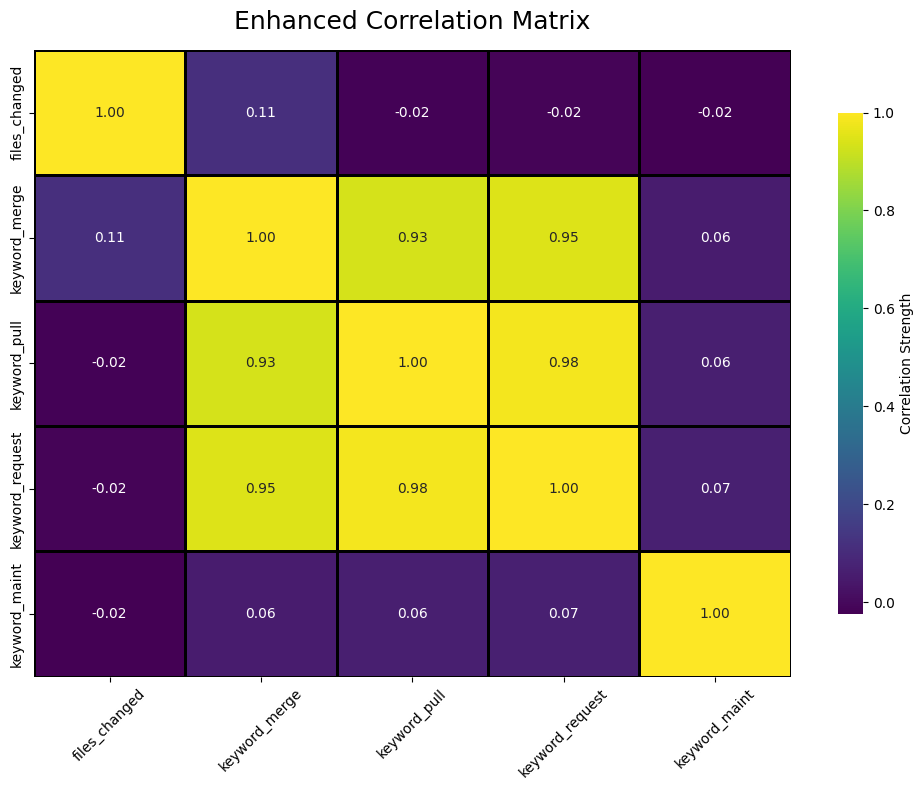

In [151]:
commit_file['count_commited_file'] = commit_file['files_commited'].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)
list_of_words = ['merge','pull','request','maint']
for word in list_of_words:
    commit_file[f'keyword_{word}'] = commit_file['message'].str.contains(word, case=False).astype(int)
matrix = commit_file[['files_changed'] + 
[f'keyword_{word}' for word in list_of_words]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrix, 
    annot=True,  
    cmap='viridis',
    fmt='.2f', 
    linewidths=1, 
    linecolor='black', 
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Strength'}  
)
plt.title("Enhanced Correlation Matrix", fontsize=18, pad=15)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

xử lí dữ liệu để chuẩn bị cho đánh giá kiểm định giả thiết và cho model

In [142]:
# Xử lý ngày tháng
commit_file['date'] = pd.to_datetime(commit_file['date'], errors='coerce')
commit_file['year'] = commit_file['date'].dt.year
commit_file['month_numeric'] = commit_file['date'].dt.month
commit_file['day'] = commit_file['date'].dt.day
commit_file['merge_count'] = commit_file['message'].str.lower().str.count('merge')

# Bước 1: Loại bỏ giá trị ngoại lai
data_filtered = commit_file[commit_file['files_changed'] < 400]

# Bước 2: Log-transform biến phụ thuộc
data_filtered['files_changed_log'] = np.log1p(data_filtered['files_changed'])

# Bước 3: Thêm đặc trưng mới: số từ trong 'message'
data_filtered['message_word_count'] = data_filtered['message'].str.split().str.len()

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\3228374587.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['files_changed_log'] = np.log1p(data_filtered['files_changed'])
C:\Users\admin\AppData\Local\Temp\ipykernel_3160\3228374587.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['message_word_count'] = data_filtered['message'].str.split().str.len()


Đánh giá kiểm định giả thiết

In [143]:

categorical_features = ['year', 'month_numeric', 'day', 'merge_count', 'message_word_count']

# Lưu kết quả
anova_results = {}

for feature in categorical_features:
    # Nhóm dữ liệu theo từng giá trị của đặc trưng
    grouped_data = [group['files_changed'].values for _, group in data_filtered.groupby(feature) if len(group) > 1]
    
    if len(grouped_data) > 1:  # Đảm bảo có ít nhất 2 nhóm
        # Thực hiện kiểm định ANOVA
        f_stat, p_value = f_oneway(*grouped_data)
        anova_results[feature] = {'F-statistic': f_stat, 'P-value': p_value}

# Hiển thị kết quả
for feature, result in anova_results.items():
    print(f"ANOVA for feature '{feature}':")
    print(f"  F-statistic: {result['F-statistic']}")
    print(f"  P-value: {result['P-value']}")
    if result['P-value'] < 0.05:
        print(f"  => Bác bỏ H₀: Có sự khác biệt ý nghĩa giữa các nhóm của '{feature}'.\n")
    else:
        print(f"  => Không bác bỏ H₀: Không có sự khác biệt ý nghĩa giữa các nhóm của '{feature}'.\n")


ANOVA for feature 'year':
  F-statistic: 0.4050427602792266
  P-value: 0.7493872003392301
  => Không bác bỏ H₀: Không có sự khác biệt ý nghĩa giữa các nhóm của 'year'.

ANOVA for feature 'month_numeric':
  F-statistic: 1.9844462567074395
  P-value: 0.026059652955597874
  => Bác bỏ H₀: Có sự khác biệt ý nghĩa giữa các nhóm của 'month_numeric'.

ANOVA for feature 'day':
  F-statistic: 1.4404723406127011
  P-value: 0.05717806240145636
  => Không bác bỏ H₀: Không có sự khác biệt ý nghĩa giữa các nhóm của 'day'.

ANOVA for feature 'merge_count':
  F-statistic: 37.8747011171817
  P-value: 5.3284154455476555e-17
  => Bác bỏ H₀: Có sự khác biệt ý nghĩa giữa các nhóm của 'merge_count'.

ANOVA for feature 'message_word_count':
  F-statistic: 2.2524914328725356
  P-value: 1.9356418366634358e-10
  => Bác bỏ H₀: Có sự khác biệt ý nghĩa giữa các nhóm của 'message_word_count'.



In [149]:
import pandas as pd

# Chuyển kết quả ANOVA sang DataFrame
anova_table = pd.DataFrame.from_dict(
    {
        feature: {
            "F-statistic": result["F-statistic"],
            "P-value": result["P-value"],
            "Conclusion": "Có khác biệt ý nghĩa" if result["P-value"] < 0.05 else "Không khác biệt ý nghĩa"
        }
        for feature, result in anova_results.items()
    },
    orient='index'
).reset_index()

# Đổi tên cột để dễ hiểu
anova_table.rename(columns={"index": "Feature"}, inplace=True)

# Hiển thị bảng
print(anova_table)

# Nếu cần xuất bảng ra file CSV
# anova_table.to_csv("anova_results.csv", index=False)


              Feature  F-statistic       P-value               Conclusion
0                year     0.405043  7.493872e-01  Không khác biệt ý nghĩa
1       month_numeric     1.984446  2.605965e-02     Có khác biệt ý nghĩa
2                 day     1.440472  5.717806e-02  Không khác biệt ý nghĩa
3         merge_count    37.874701  5.328415e-17     Có khác biệt ý nghĩa
4  message_word_count     2.252491  1.935642e-10     Có khác biệt ý nghĩa


Model dự đoán và đánh giá mô hình

In [145]:

# Chuẩn bị dữ liệu
features = ['merge_count', 'year', 'month_numeric', 'day', 'message_word_count']
X_filtered = data_filtered[features]
y_filtered = data_filtered['files_changed_log']

# Chia tập dữ liệu
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Cấu hình mô hình XGBoost
xgb_model_improved = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,  
    max_depth=3,       
    learning_rate=0.04,  
    random_state=42
)

# Huấn luyện mô hình
xgb_model_improved.fit(X_train_f, y_train_f)

# Đánh giá mô hình
y_pred_f = xgb_model_improved.predict(X_test_f)
mse_f = mean_squared_error(y_test_f, y_pred_f)
rmse_f = np.sqrt(mse_f)

# Tầm quan trọng của đặc trưng
feature_importance_f = xgb_model_improved.feature_importances_

print(f"RMSE (log-transformed): {rmse_f}")
print("Feature Importance:", feature_importance_f)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_f, y_pred_f)
print(f"R²: {r2}")

RMSE (log-transformed): 0.6378115862062003
Feature Importance: [0.3982467  0.06011343 0.09148914 0.09301004 0.35714066]
R²: 0.23224564757567756


Trực quan hóa model

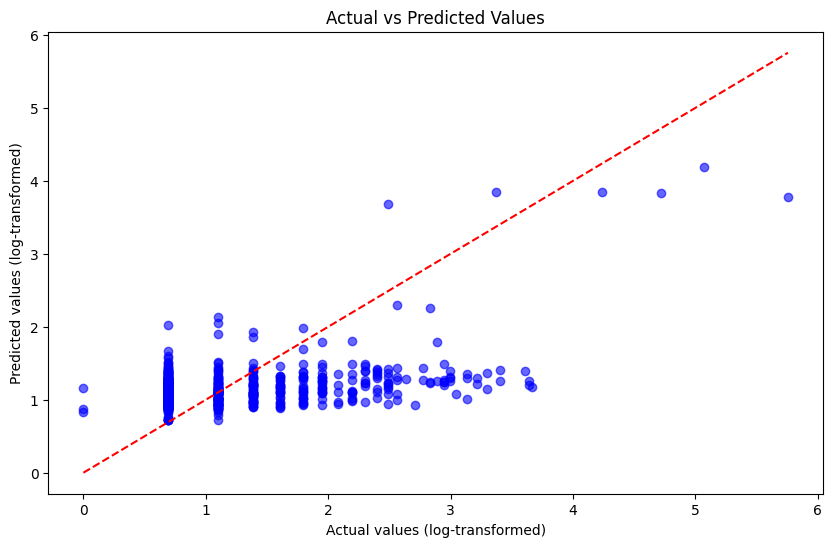

C:\Users\admin\AppData\Local\Temp\ipykernel_3160\1987214650.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")


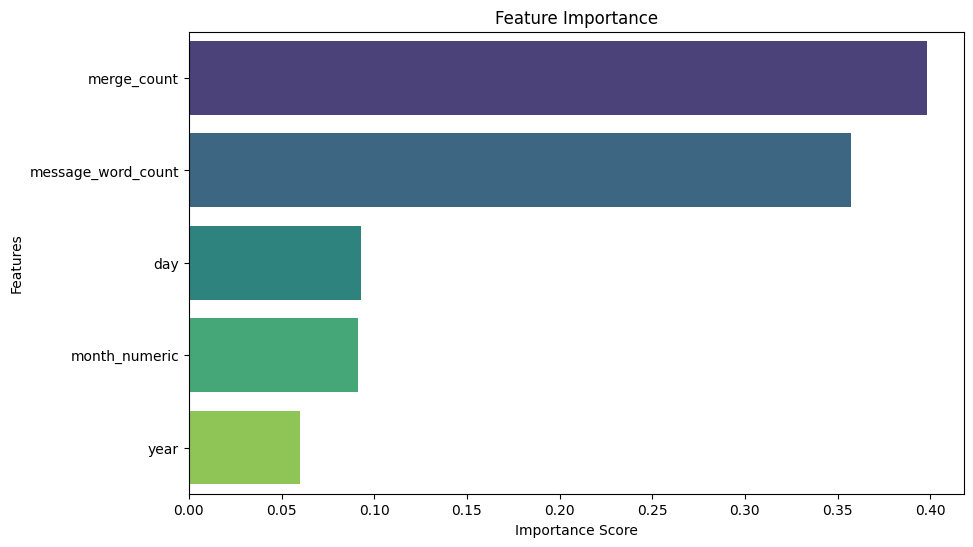

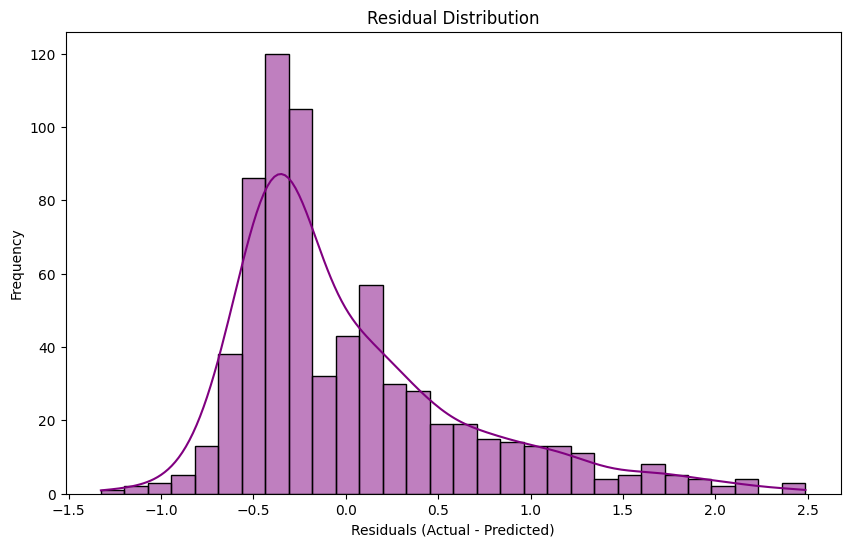

In [146]:


# 1. Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_f, y_pred_f, alpha=0.6, color="blue")
plt.plot([y_test_f.min(), y_test_f.max()], [y_test_f.min(), y_test_f.max()], color="red", linestyle="--")
plt.xlabel("Actual values (log-transformed)")
plt.ylabel("Predicted values (log-transformed)")
plt.title("Actual vs Predicted Values")
plt.show()

# 2. Feature importance visualization
feature_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance_f
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 3. Error distribution (Residuals)
residuals = y_test_f - y_pred_f

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color="purple")
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


<>:4: SyntaxWarning: invalid escape sequence '\g'
<>:4: SyntaxWarning: invalid escape sequence '\g'
C:\Users\PC\AppData\Local\Temp\ipykernel_14408\3505132766.py:4: SyntaxWarning: invalid escape sequence '\g'
  commits_df = pd.read_csv('D:\github_repo\PYTHON_BAOCAO\DATA_PYTHON\data_processed\commits.csv')


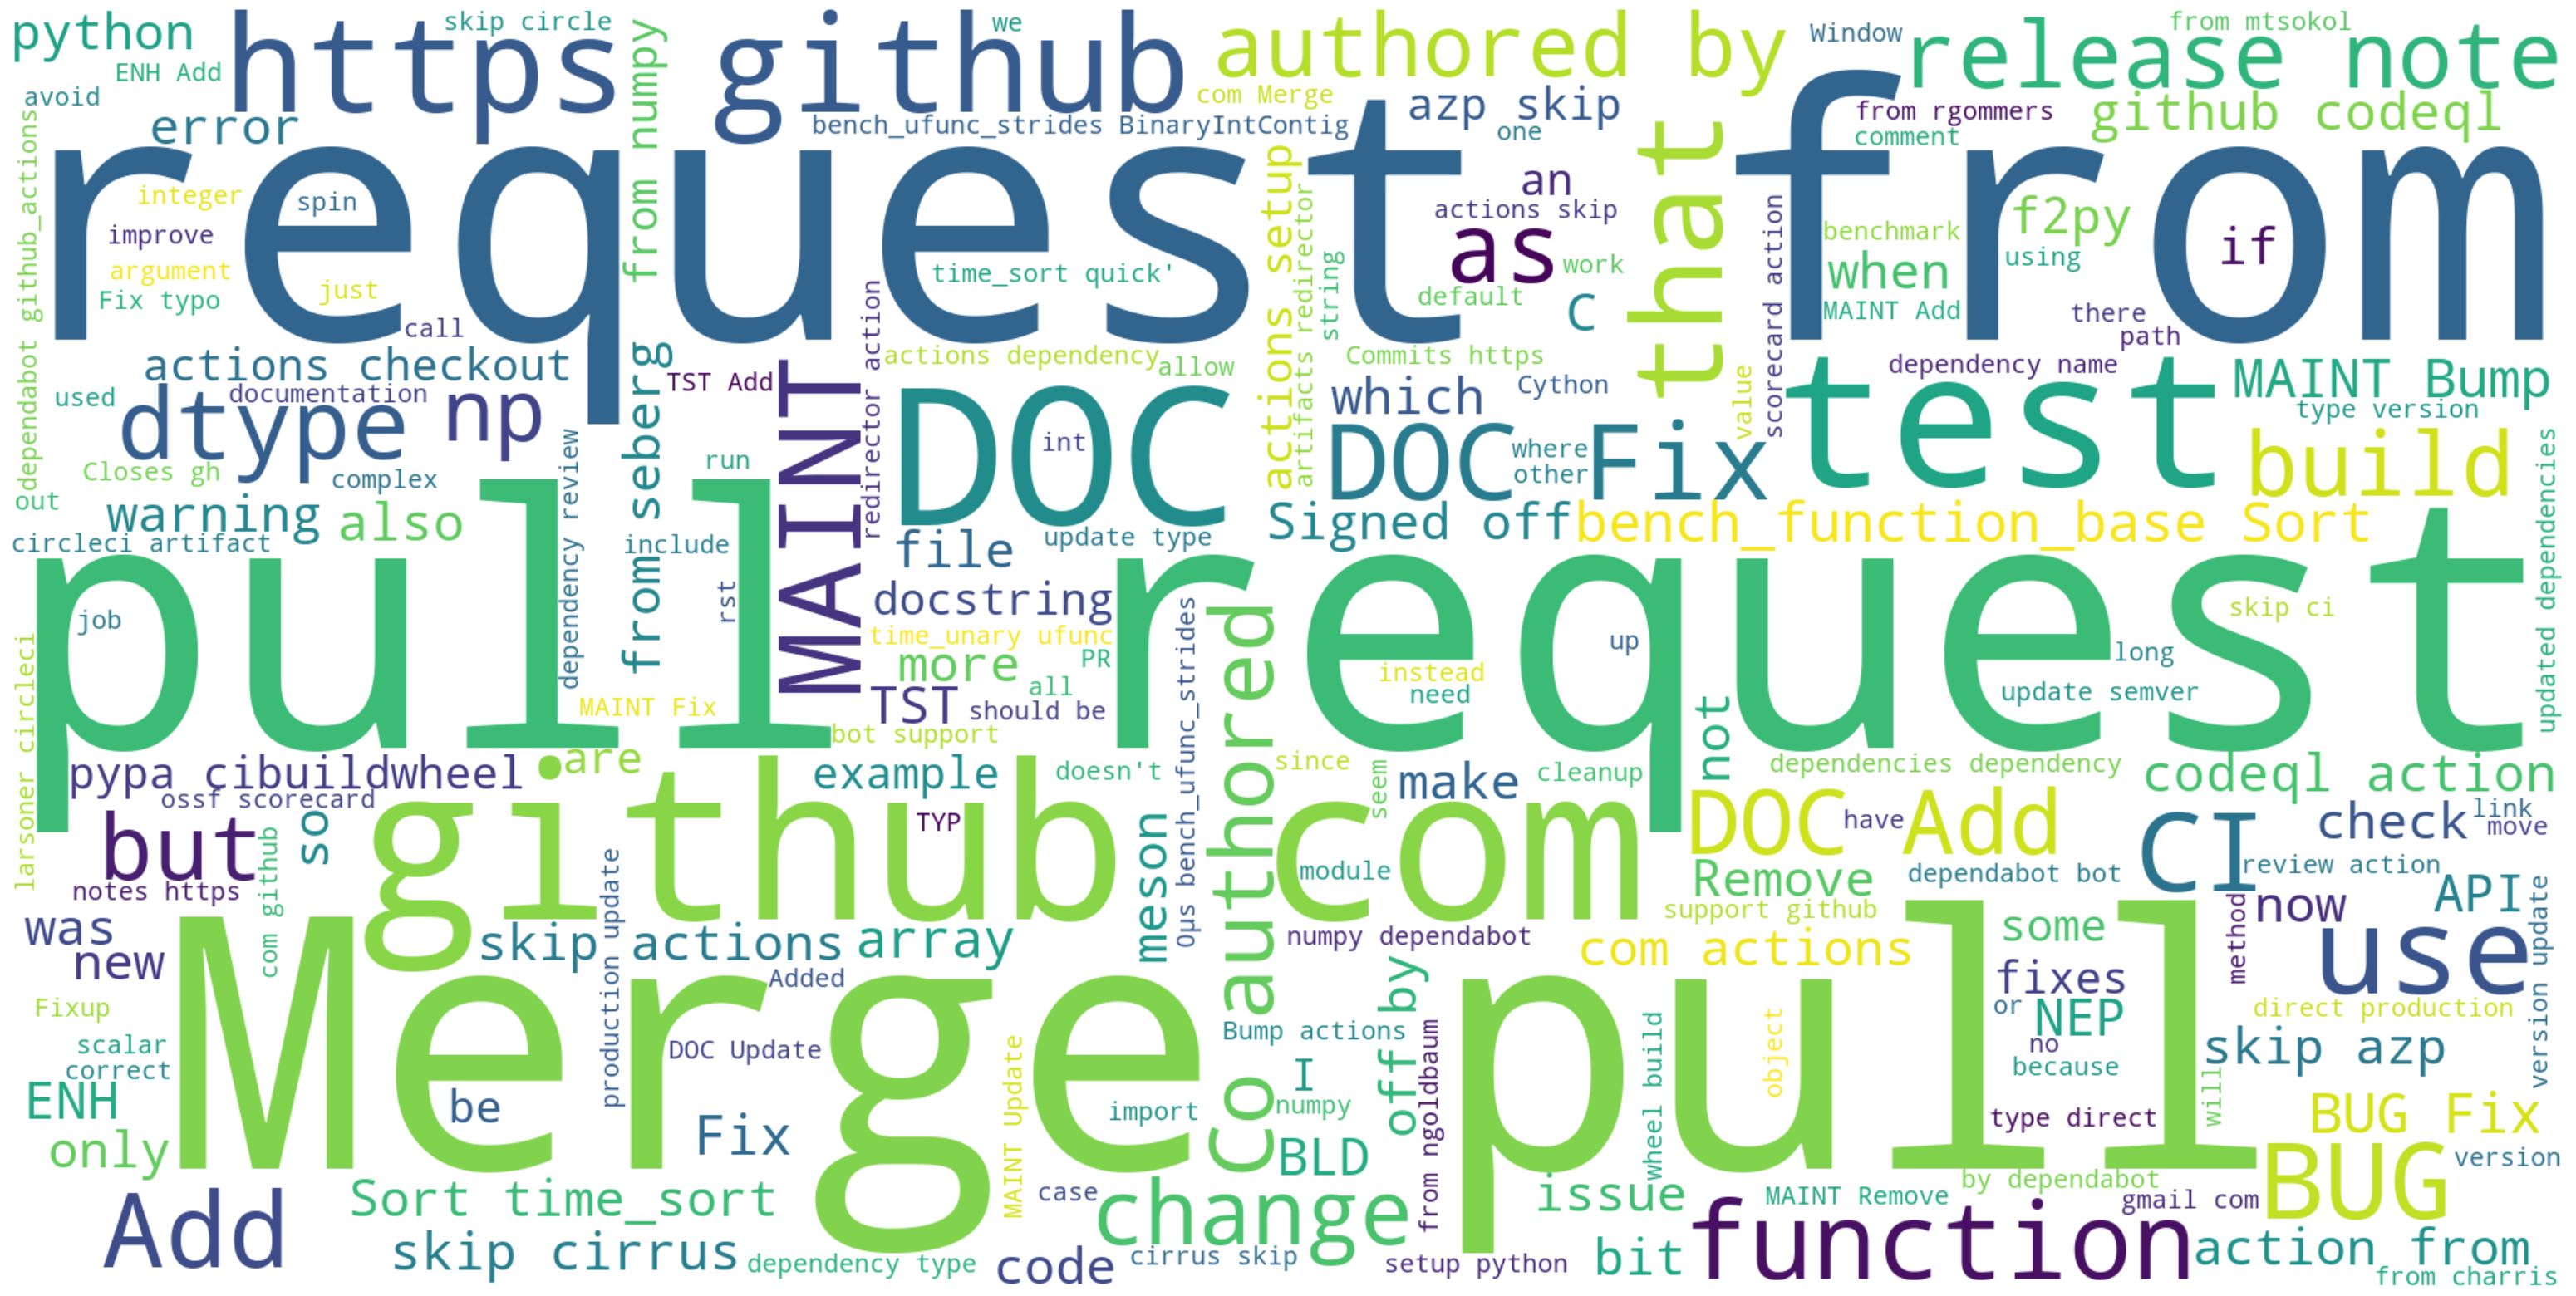

In [2]:
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
commits_df = pd.read_csv('D:\github_repo\PYTHON_BAOCAO\DATA_PYTHON\data_processed\commits.csv')

all_messages = ' '.join(commits_df['message'])
wordcloud = WordCloud(width=2000, height=1000, background_color='white', colormap='viridis', 
                      stopwords=set(['the', 'and', 'to', 'of', 'in', 'a', 'for', 'on', 'with', 'is', 'this', 'it'])).generate(all_messages)

# Vẽ ảnh
plt.figure(figsize=(40, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

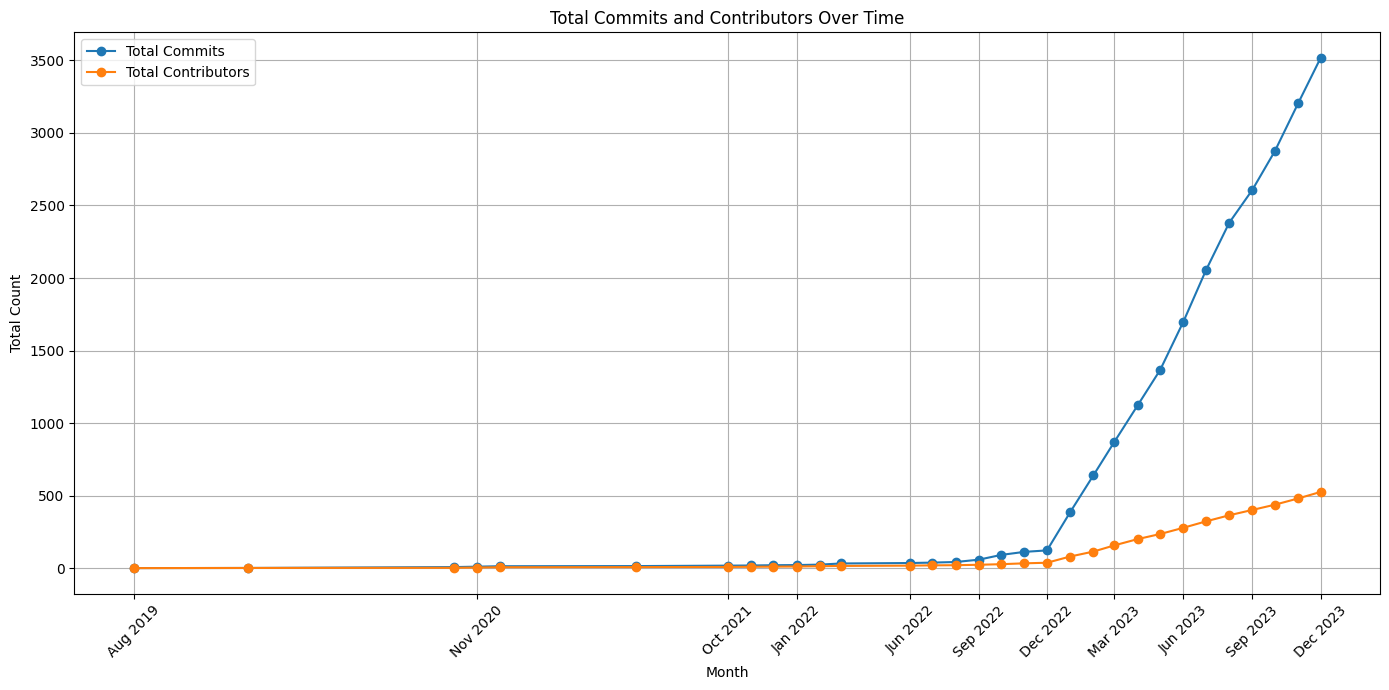

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu
data = pd.read_csv('data_processed/growth.csv', index_col='month')

# Chuyển cột index về dạng datetime
data.index = pd.to_datetime(data.index)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Total Commits'], marker='o', label='Total Commits')
plt.plot(data.index, data['Total Contributors'], marker='o', label='Total Contributors')

# Định dạng biểu đồ
plt.title('Total Commits and Contributors Over Time')
plt.xlabel('Month')
plt.ylabel('Total Count')
plt.legend()
plt.grid(True)

# Định dạng nhãn trục x
plt.xticks(ticks=data.index[::3], labels=data.index.strftime('%b %Y')[::3], rotation=45)

plt.tight_layout()
plt.show()
